# PROJET ML — CLASSIFICATION DE VIDÉOS YOUTUBE *TRENDING*

**Dataset Kaggle**: https://www.kaggle.com/datasets/datasnaek/youtube-new

**Objectif**: Développer un classificateur pour prédire si une vidéo YouTube deviendra *trending*.

> Ce notebook est conçu pour être complété. Chaque section contient des consignes détaillées et des zones de code à compléter.


## 1. Importation des librairies

**Consigne 1.1 — Importez toutes les librairies nécessaires**
- `pandas`, `numpy` pour la manipulation de données  
- `matplotlib.pyplot`, `seaborn` pour la visualisation  
- `sklearn` pour le machine learning  
- `warnings` pour supprimer les avertissements

In [17]:
# VOTRE CODE ICI - Section 1.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import json
import datetime 
# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')
print("Kirill")

Kirill


## 2. Chargement et exploration des données

**Consigne 2.1 — Chargement des données**
- Chargez le fichier `USvideos.csv` avec pandas  
- Affichez les 5 premières lignes  
- Affichez les informations générales (`info()`, `shape`, `describe()`)

*Aide* :
- Utilisez `pd.read_csv()` avec `encoding='utf-8'`
- `.info()` donne les types de colonnes et valeurs non-nulles
- `.describe()` donne les statistiques descriptives

In [3]:
# VOTRE CODE ICI - Section 2.1

df = pd.read_csv('~/youtube-popularity-ml/archive/USvideos.csv', encoding='utf-8')
print("Premières lignes: ", df.head())
display(df.head())
print("\nInformations générales:", df.info())
display(df.info())
print("Shape:", df.shape)
display(df.describe(include='all').transpose())

Premières lignes:        video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

None

Shape: (40949, 16)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
video_id,40949,6351,j4KvrAUjn6c,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trending_date,40949,205,17.14.11,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,40949,6455,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_title,40949,2207,ESPN,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_id,40949.0,NaN,NaN,NaN,19.972429,7.568327,1.0,17.0,24.0,25.0,43.0
publish_time,40949,6269,2018-05-18T14:00:04.000Z,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tags,40949,6055,[none],1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
views,40949.0,NaN,NaN,NaN,2360784.638257,7394113.759704,549.0,242329.0,681861.0,1823157.0,225211923.0
likes,40949.0,NaN,NaN,NaN,74266.702435,228885.338209,0.0,5424.0,18091.0,55417.0,5613827.0
dislikes,40949.0,NaN,NaN,NaN,3711.400889,29029.705945,0.0,202.0,631.0,1938.0,1674420.0


**Consigne 2.2 — Analyse des valeurs manquantes**  
- Comptez les valeurs manquantes par colonne  
- Identifiez les colonnes avec le plus de valeurs manquantes  
- Affichez le pourcentage de valeurs manquantes

In [4]:
# VOTRE CODE ICI - Section 2.2
missing = df.isna().sum()
pct_missing = (missing / len(df)) * 100
print("Valeurs manquantes (nombre):")
display(missing)
print("\nValeurs manquantes (pourcentage):")
display(pct_missing)

Valeurs manquantes (nombre):


video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64


Valeurs manquantes (pourcentage):


video_id                  0.000000
trending_date             0.000000
title                     0.000000
channel_title             0.000000
category_id               0.000000
publish_time              0.000000
tags                      0.000000
views                     0.000000
likes                     0.000000
dislikes                  0.000000
comment_count             0.000000
thumbnail_link            0.000000
comments_disabled         0.000000
ratings_disabled          0.000000
video_error_or_removed    0.000000
description               1.391975
dtype: float64

**Consigne 2.3 — Exploration des catégories**  
- Chargez le fichier JSON des catégories (`US_category_id.json`)  
- Fusionnez avec le DataFrame principal  
- Affichez la distribution des catégories

*Aide* : La structure JSON est du type:  
`{"items": [{"id": "1", "snippet": {"title": "Film & Animation"}}, ...]}`

In [5]:
# VOTRE CODE ICI - Section 2.3
import pandas as pd
import json
categories_raw = pd.read_json('~/youtube-popularity-ml/archive/US_category_id.json')
items = categories_raw['items'].tolist()
category_dict = {int(item['id']): item['snippet']['title'] for item in items}
cat_df = pd.DataFrame(list(category_dict.items()), columns=['category_id', 'category_title'])
df_merged = df.merge(cat_df, how='left', left_on='category_id', right_on='category_id')
print("Distribution des catégories:")
display(df_merged['category_title'].value_counts().to_frame('count'))

Distribution des catégories:


,count
category_title,
Entertainment,9964
Music,6472
Howto & Style,4146
Comedy,3457
People & Blogs,3210
News & Politics,2487
Science & Technology,2401
Film & Animation,2345
Sports,2174


## 3. Nettoyage des données

**Consigne 3.1 — Nettoyage des données**
- Supprimez les doublons basés sur `video_id`  
- Gérez les valeurs manquantes dans `description` (remplacez par string vide)  
- Convertissez `publish_time` en datetime  
- Supprimez les lignes avec des valeurs aberrantes (ex: `views` négatives)

In [6]:
# VOTRE CODE ICI - Section 3.1
df_clean = df.drop_duplicates(subset='video_id').copy()
df_clean['description'] = df_clean['description'].fillna('')
display(df_clean.isna().sum())
import pandas as pd
df_clean['publish_time'] = pd.to_datetime(df_clean['publish_time'], errors='coerce')
# df_clean['publish_time'] =  errors='coerce'
df_clean = df_clean[(df_clean['views'] >= 0) & (df_clean['likes'] >= 0) & (df_clean['dislikes'] >= 0) & (df_clean['comment_count'] >= 0)]
df_clean = df_clean.dropna(subset=['publish_time'])


video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
description               0
dtype: int64

## 4. Feature Engineering

**Consigne 4.1 — Variables d'engagement**
** définition : https://support.google.com/youtube/answer/2991785?hl=fr**

In [7]:
# VOTRE CODE ICI - Section 4.1
import numpy as np
eps = 1e-9
denom = df_clean['likes'] + df_clean['dislikes']
df_clean['like_ratio'] = np.where(denom > 0, df_clean['likes'] / denom, 0)
df_clean['engagement_rate'] = np.where(df_clean['views'] > 0,
                                       (df_clean['likes'] + df_clean['dislikes'] + df_clean['comment_count']) / (df_clean['views'] + eps),
                                       0)

df_clean['comments_per_view'] = np.where(df_clean['views'] > 0, df_clean['comment_count'] / (df_clean['views'] + eps), 0)

display(df_clean['engagement_rate'])
display(df_clean['comments_per_view'])

0        0.102151
1        0.047972
2        0.049994
3        0.037836
4        0.072405
           ...   
40760    0.050341
40761    0.012950
40762    0.023472
40764    0.029825
40766    0.031101
Name: engagement_rate, Length: 6351, dtype: float64

0        0.021318
1        0.005252
2        0.002563
3        0.006253
4        0.008359
           ...   
40760    0.005790
40761    0.003082
40762    0.001243
40764    0.002242
40766    0.002579
Name: comments_per_view, Length: 6351, dtype: float64

**Consigne 4.2 — Variables temporelles**

In [8]:
# VOTRE CODE ICI - Section 4.2
df_clean['publish_hour'] = df_clean['publish_time'].dt.hour
display(df_clean['publish_hour'])
df_clean['publish_day_of_week'] = df_clean['publish_time'].dt.weekday
display(df_clean['publish_day_of_week'])
df_clean['publish_month'] = df_clean['publish_time'].dt.month
display(df_clean['publish_month'])

0        17
1         7
2        19
3        11
4        18
         ..
40760    18
40761    15
40762     5
40764    16
40766     9
Name: publish_hour, Length: 6351, dtype: int32

0        0
1        0
2        6
3        0
4        6
        ..
40760    1
40761    2
40762    2
40764    1
40766    2
Name: publish_day_of_week, Length: 6351, dtype: int32

0        11
1        11
2        11
3        11
4        11
         ..
40760     6
40761     6
40762     6
40764     6
40766     6
Name: publish_month, Length: 6351, dtype: int32

**Consigne 4.3 — Variables textuelles (titre)**

In [9]:
# VOTRE CODE ICI - Section 4.3

df_clean['title_length'] = df_clean['title'].str.len()
display(df_clean['title_length'])
df_clean['title_word_count'] = df_clean['title'].str.rsplit().str.len()
display(df_clean['title_word_count'])
df_clean['has_caps'] = df_clean['title'].str.contains(r'[A-Z]')
display(df_clean['has_caps'])
df_clean['has_numbers'] = df_clean['title'].str.contains(r'[0-9]')
display(df_clean['has_numbers'])

0        34
1        62
2        53
3        32
4        24
         ..
40760    29
40761    94
40762    49
40764    65
40766    64
Name: title_length, Length: 6351, dtype: int64

0         7
1        10
2        10
3         5
4         5
         ..
40760     6
40761    16
40762    10
40764    12
40766    10
Name: title_word_count, Length: 6351, dtype: int64

0        True
1        True
2        True
3        True
4        True
         ... 
40760    True
40761    True
40762    True
40764    True
40766    True
Name: has_caps, Length: 6351, dtype: bool

0        False
1        False
2        False
3        False
4        False
         ...  
40760    False
40761    False
40762    False
40764    False
40766     True
Name: has_numbers, Length: 6351, dtype: bool

## 5. Création de la variable cible

**Consigne 5.1 — Définition de `is_trending`**  
- Une vidéo est *trending* si elle a plus de vues que le 80e percentile de sa catégorie

In [10]:
# VOTRE CODE ICI - Section 5.1
df_clean['is_trending'] = (df_clean.groupby('category_id')['views']
                                  .transform(lambda x: x > x.quantile(0.8))).astype(int)
print("Distribution de la variable cible:")
display(df_clean['is_trending'].value_counts().to_frame('count'))

Distribution de la variable cible:


,count
is_trending,
0,5078
1,1273


## 6. Préparation des données pour l'entraînement

**Consignes 6.1 & 6.2 — Sélection des features & split train/test**

In [11]:
# VOTRE CODE ICI - Section 6.1 et 6.2

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

features = ['views', 'likes', 'dislikes', 'comment_count',
            'like_ratio', 'engagement_rate', 'title_length', 'publish_hour', 'category_id']
X = df_clean[features].copy()
y = df_clean['is_trending'].copy()

# Split AVANT d'entraîner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sélection du modèle
clf = svm.SVC()

# Fit sur train uniquement
clf.fit(X_train, y_train)

# Prédictions sur test
pred = clf.predict(X_test)

print(f"Taille train: {X_train.shape}")
print(f"Taille test: {X_test.shape}")
display(f'Accuracy : ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


Taille train: (5080, 9)
Taille test: (1271, 9)


'Accuracy : '

0.9354838709677419

[[989  12]
 [ 70 200]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1001
           1       0.94      0.74      0.83       270

    accuracy                           0.94      1271
   macro avg       0.94      0.86      0.90      1271
weighted avg       0.94      0.94      0.93      1271



**Consigne 6.3 — Normalisation des données (StandardScaler)**

In [23]:
# VOTRE CODE ICI - Section 6.3
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['views', 'likes', 'dislikes', 'comment_count', 'like_ratio', 'engagement_rate', 'title_length', 'publish_hour', 'category_id']
# Fit uniquement sur train
scaled = scaler.fit_transform(X[num_cols])
predict = clf.predict(X_test)

acc = accuracy_score(y_test, predict)
print("Avant : ")
print(X[num_cols])
print("Après : ")
print(scaled)


Avant : 
         views   likes  dislikes  comment_count  like_ratio  engagement_rate  \
0       748374   57527      2966          15954    0.950970         0.102151   
1      2418783   97185      6146          12703    0.940521         0.047972   
2      3191434  146033      5339           8181    0.964729         0.049994   
3       343168   10172       666           2146    0.938550         0.037836   
4      2095731  132235      1989          17518    0.985181         0.072405   
...        ...     ...       ...            ...         ...              ...   
40760   607422   26166       895           3517    0.966927         0.050341   
40761   812832    7701       320           2505    0.960105         0.012950   
40762   864189   18811       399           1074    0.979230         0.023472   
40764   540149   14206       693           1211    0.953487         0.029825   
40766   296295    8157       294            764    0.965211         0.031101   

       title_length  publish_h

In [13]:
# Entrainement du modèle avec les données normalisées
# Split AVANT d'entraîner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(y_pred)
print('Accuracy :', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Rapport de classification : ')
print(classification_report(y_test, y_pred))


[0 0 0 ... 0 0 0]
Accuracy : 0.953579858379229
[[994   7]
 [ 52 218]]
Rapport de classification : 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1001
           1       0.97      0.81      0.88       270

    accuracy                           0.95      1271
   macro avg       0.96      0.90      0.93      1271
weighted avg       0.95      0.95      0.95      1271



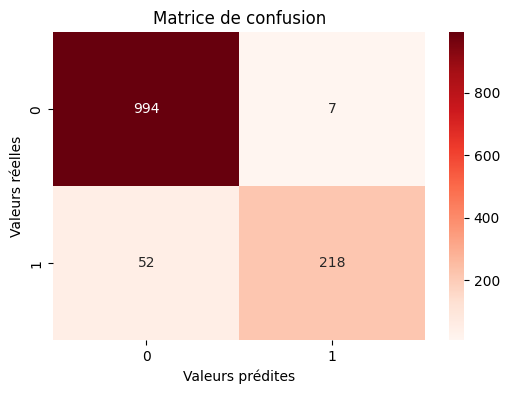

In [14]:
# Visualisation

# Matrice de confusion

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Reds')
plt.ylabel('Valeurs réelles')
plt.xlabel('Valeurs prédites')
plt.title('Matrice de confusion')
plt.show()

## Analyse résultats
### Accuracy : 95% de vidéos bien classées par le modèle
### Matrice de confusion
- 994 vidéos vrai positifs / 218 vrais négatifs
- 7 vidéos faux positifs / 52 faux négatifs
### Rapport de classification
#### 0 -> Non trending
- Precision :  95% bien classées
- Recall : 99% de vidéos réellement non trending
- f1-score : 97% (rapport entre precision et recall)
#### 1 -> Trending
- Precision : 97% bien classées
- Recall : 81% réellement prédites comme trending
- f1-score : 88% 

## 7. Modèle 1 — Random Forest

**Consigne 7.1 — Entraînement**

In [18]:
# VOTRE CODE ICI - Section 7.1
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Modèle
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)
# Prédictions sur le test set
rf_predictions = rf_model.predict(X_test)

**Consigne 7.2 — Évaluation**

In [22]:
# VOTRE CODE ICI - Section 7.2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Random Forest - Résultats:")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"Precision: {precision_score(y_test, rf_predictions):.4f}")
print(confusion_matrix(y_test, rf_predictions))
print(f"Classification report: {classification_report(y_test, rf_predictions)}")
print(f"Recall: {recall_score(y_test, rf_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_predictions):.4f}")
# Importance des variables
import pandas as pd
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 variables importantes:")
display(feature_importance.head(10))

Random Forest - Résultats:
Accuracy: 0.9709
Precision: 0.9533
[[989  12]
 [ 25 245]]
Classification report:               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1001
           1       0.95      0.91      0.93       270

    accuracy                           0.97      1271
   macro avg       0.96      0.95      0.96      1271
weighted avg       0.97      0.97      0.97      1271

Recall: 0.9074
F1-Score: 0.9298

Top 10 variables importantes:


,feature,importance
0,views,0.516017
2,dislikes,0.154871
1,likes,0.085971
8,category_id,0.084005
3,comment_count,0.062769
5,engagement_rate,0.045443
4,like_ratio,0.020442
6,title_length,0.015881
7,publish_hour,0.014601


## 8. Modèle 2 — Support Vector Machine (SVM)

**Consigne 8.1 — Entraînement (utiliser données normalisées)**

In [ ]:
# VOTRE CODE ICI - Section 8.1
# Cf. Consigne 6.3

**Consigne 8.2 — Évaluation**

In [ ]:
# VOTRE CODE ICI - Section 8.2
# print("SVM - Résultats:")
# print(f"Accuracy: {accuracy_score(y_test, svm_predictions):.4f}")
#....
# ...
# ...

## 9. Modèle 3 — Gradient Boosting (XGBoost)

**Consigne 9.1 — Entraînement**

In [25]:
# VOTRE CODE ICI - Section 9.1
try:
    from xgboost import XGBClassifier
    xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, random_state=42, n_jobs=-1, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
except ImportError:
    print("XGBoost n'est pas installé. Installez avec: pip install xgboost")
    xgb_model = None
    xgb_predictions = None

**Consigne 9.2 — Évaluation**

In [26]:
# VOTRE CODE ICI - Section 9.2
from sklearn.metrics import precision_score, recall_score, f1_score

if xgb_predictions is not None:
    print("XGBoost - Résultats:")
    print(f"Accuracy: {accuracy_score(y_test, xgb_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, xgb_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, xgb_predictions):.4f}")
    print(f"F1-Score: {f1_score(y_test, xgb_predictions):.4f}")

XGBoost - Résultats:
Accuracy: 0.9921
Precision: 0.9924
Recall: 0.9704
F1-Score: 0.9813


## 10. Modèle 4 — Réseau de Neurones (MLPClassifier)

**Consigne 10.1 — Entraînement (données normalisées)**

In [27]:
# VOTRE CODE ICI - Section 10.1
from sklearn.neural_network import MLPClassifier
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)

nn_model.fit(X_train_scaled, y_train)
nn_predictions = nn_model.predict(X_test_scaled)

**Consigne 10.2 — Évaluation**

In [ ]:
# VOTRE CODE ICI - Section 10.2
print("Réseau de Neurones - Résultats:")

print(f"Precision: {precision_score(y_test, nn_predictions):.4f}")
print(f"Recall: {recall_score(y_test, nn_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, nn_predictions):.4f}")
# Nombre d'itérations
print(f'Nb itérations : {nn_model.n_iter_}')

Réseau de Neurones - Résultats:
Precision: 0.9180
Recall: 0.8704
F1-Score: 0.8935
Nb itération : 211


## 11. Comparaison des modèles

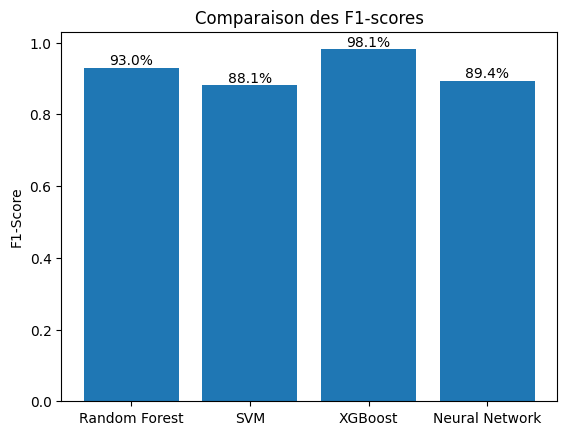

In [28]:
# VOTRE CODE ICI - Section 11.1
import pandas as pd
results = []
# Remplir en fonction des métriques calculées plus haut
results.append({'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, rf_predictions), 'Precision': precision_score(y_test, rf_predictions), 'Recall': recall_score(y_test, rf_predictions), 'F1-Score': f1_score(y_test, rf_predictions)})
results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': precision_score(y_test, predict), 'Recall': recall_score(y_test, predict), 'F1-Score': f1_score(y_test, predict)})
if xgb_predictions is not None: results.append({'Model': 'XGBoost', 'Accuracy': accuracy_score(y_test, xgb_predictions), 'Precision': precision_score(y_test, xgb_predictions), 'Recall': recall_score(y_test, xgb_predictions), 'F1-Score': f1_score(y_test, xgb_predictions)})
results.append({'Model': 'Neural Network', 'Accuracy': accuracy_score(y_test, nn_predictions), 'Precision': precision_score(y_test, nn_predictions), 'Recall': recall_score(y_test, nn_predictions), 'F1-Score': f1_score(y_test, nn_predictions)})
results_df = pd.DataFrame(results)
# display(results_df)
# Graphique comparatif des F1-scores (optionnel)
import matplotlib.pyplot as plt
plt.figure()
bars = plt.bar(results_df['Model'], results_df['F1-Score'])
# Affichage % 
plt.bar_label(bars, labels=[f'{v*100:.1f}%' for v in results_df['F1-Score']])
plt.title('Comparaison des F1-scores')
plt.ylabel('F1-Score')
plt.show()

## 12. Validation croisée

In [31]:
# VOTRE CODE ICI - Section 12.1
from sklearn.model_selection import cross_val_score
# # Exemple avec Random Forest (remplacez par votre meilleur modèle)
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"Validation croisée - F1-Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Validation croisée - F1-Score: 0.9774 (+/- 0.0155)


## 13. Optimisation des hyperparamètres (Grid Search)

In [32]:
# VOTRE CODE ICI - Section 13.1
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score CV:", grid_search.best_score_)
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)

Meilleurs paramètres: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Meilleur score CV: 0.9759101911018764


## 14. Analyse des erreurs

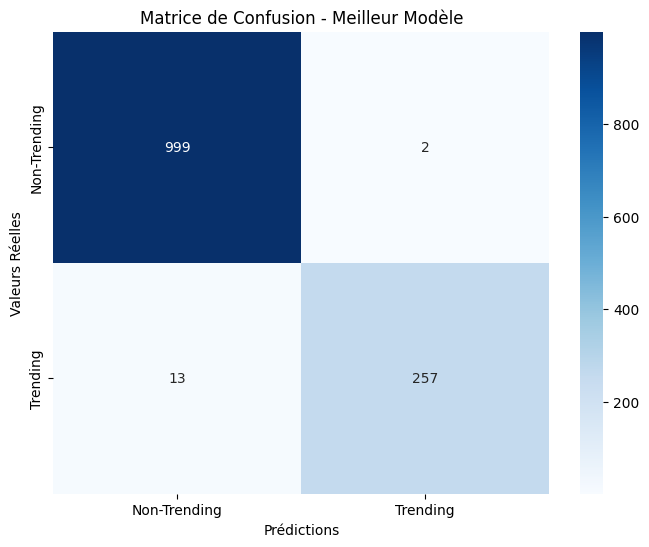

In [33]:
# VOTRE CODE ICI - Section 14.1
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Exemple: matrice de confusion pour le meilleur modèle (remplacez best_rf_pred)
cm = confusion_matrix(y_test, best_rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Trending', 'Trending'],
            yticklabels=['Non-Trending', 'Trending'])
plt.title('Matrice de Confusion - Meilleur Modèle')
plt.ylabel('Valeurs Réelles')
plt.xlabel('Prédictions')
plt.show()

In [34]:
# VOTRE CODE ICI - Section 14.2
# # Identifier des exemples mal classifiés (adapter selon le modèle choisi)
errors_mask = (y_test != best_rf_pred)
error_indices = X_test[errors_mask].index
print("Exemples de vidéos mal classifiées:")
for idx in list(error_indices)[:5]:
    real_label = y_test.loc[idx]
    predicted_label = best_rf_pred[list(error_indices).index(idx)]  # à adapter si nécessaire
    print(f"Index {idx}: Réel={real_label}, Prédit={predicted_label}")

Exemples de vidéos mal classifiées:
Index 257: Réel=0, Prédit=0
Index 36752: Réel=1, Prédit=0
Index 21580: Réel=1, Prédit=0
Index 20974: Réel=1, Prédit=0
Index 6807: Réel=1, Prédit=0


## 15. Sauvegarde & conclusions

In [ ]:
# VOTRE CODE ICI - Section 15.1
# import joblib
# # Remplacez 'best_rf' / 'scaler' par vos objets
# # joblib.dump(best_model, 'best_youtube_classifier.pkl')
# # joblib.dump(scaler, 'feature_scaler.pkl')
# # print("Modèle et scaler sauvegardés avec succès!")

### Conclusions à rédiger

1. **Meilleur modèle**  
   - Modèle: *[À compléter]*  
   - Performances: *[À compléter]*  
   - Raisons: *[À compléter]*

2. **Variables les plus importantes**  
   - *[À compléter]*

3. **Limitations**  
   - *[À compléter]*

4. **Améliorations suggérées**  
   - *[À compléter]*

5. **Apprentissages**  
   - *[À compléter]*

---
## Guide de testing pour les étudiants

**Comment tester vos implémentations :**
1. **Vérifications de base** : `.shape`, `.info()`, `.head()`  
2. **Validation des features** : pas de NaN, ratios entre 0 et 1, plages temporelles correctes  
3. **Validation des modèles** : prédictions binaires {0,1}, longueurs cohérentes, comparaisons rigoureuses  
4. **Tests de cohérence** : scores réalistes, F1 entre précision et rappel, impact de la normalisation  
5. **Debugging** : augmenter `max_iter` si nécessaire, vérifier entrées/sorties et dimensions